In [1]:
import os
import json
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import show, output_notebook, figure
from sklearn import linear_model

matplotlib.style.use('ggplot')
%matplotlib inline
output_notebook(resources=bokeh.resources.INLINE)

Loading BokehJS ...

In [2]:
data_path = "./Data"
os.chdir(data_path)

In [3]:
# Load and plot the oil price data

# Cutoff date has been chosen visually based on graphs to ignore the period where the unemployment
# rate doesn't seem correlated with unemployment; extra observations for smoothing and shifting have
# been factored in
cutoff = datetime.datetime(2007, 5, 1)

oil_price = pd.read_csv("oil_price.csv", parse_dates=True, squeeze=True, index_col=0)
oil_price = oil_price[oil_price.index > cutoff]
oil_price.replace(to_replace='.', value=None, inplace=True)
oil_price = pd.to_numeric(oil_price)
oil_price = pd.rolling_mean(oil_price, 5, center=True)

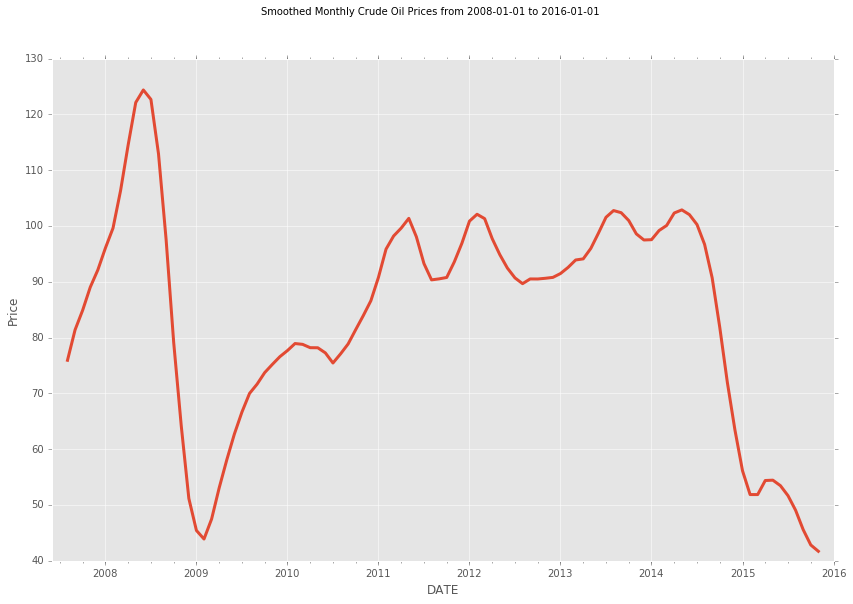

In [4]:
oil_price.plot(linewidth=3)
plt.suptitle('Smoothed Monthly Crude Oil Prices from 2008-01-01 to 2016-01-01')
plt.ylabel('Price')
plt.gcf().set_size_inches(14, 9, forward=True)

In [5]:
# Load, clean and plot the unemployment data for Canada

# Data taken from http://economicdashboard.albertacanada.com/Unemployment

canada_unemp_edb = pd.read_csv('Canada_unemp_rate.csv', index_col=0, parse_dates=True)
canada_unemp_edb = canada_unemp_edb[canada_unemp_edb.index > cutoff]

canada_unemp_edb['AgeGroup'] = canada_unemp_edb['AgeGroup'].astype('category')
canada_unemp_edb['Sex'] = canada_unemp_edb['Sex'].astype('category')

over15 = canada_unemp_edb['AgeGroup'].cat.categories[1]

canada_unemp_males_over15 = \
    canada_unemp_edb[(canada_unemp_edb['Sex'] == 'Males') & (canada_unemp_edb['AgeGroup'] == over15)]

canada_unemp_females_over15 = \
    canada_unemp_edb[(canada_unemp_edb['Sex'] == 'Females') & (canada_unemp_edb['AgeGroup'] == over15)]

del canada_unemp_males_over15['AgeGroup']
del canada_unemp_males_over15['Sex']
del canada_unemp_females_over15['AgeGroup']
del canada_unemp_females_over15['Sex']
    
male_factor = 0.5

canada_unemp_over15 = (canada_unemp_males_over15 * male_factor + 
                       canada_unemp_females_over15 * (1 - male_factor))

canada_unemp_over15 = pd.rolling_mean(canada_unemp_over15, 5, center=True)

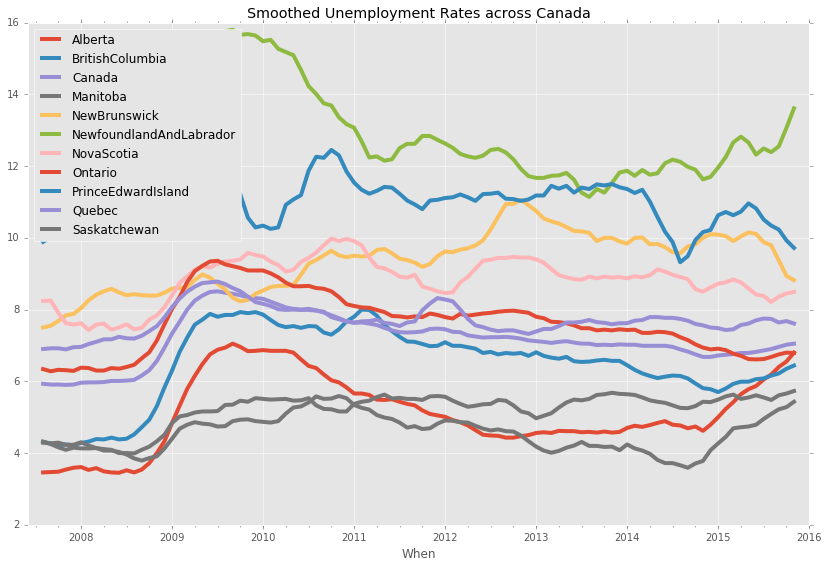

In [6]:
canada_unemp_over15.plot(title='Smoothed Unemployment Rates across Canada', linewidth=4)
plt.gcf().set_size_inches(14, 9, forward=True)

In [7]:
# Add oil price shifts to the unemployment dataframe

oilp_vs_unemp = canada_unemp_over15.copy()

for i in range(6):
    oilp_vs_unemp = pd.concat([oil_price.shift(i), oilp_vs_unemp], axis=1)
    oilp_vs_unemp.rename(columns = {'VALUE': 'OilPrice{}'.format(i)}, inplace=True)

oilp_vs_unemp.dropna(inplace=True)
oilp_vs_unemp.head()

,OilPrice5,OilPrice4,OilPrice3,OilPrice2,OilPrice1,OilPrice0,Alberta,BritishColumbia,Canada,Manitoba,NewBrunswick,NewfoundlandAndLabrador,NovaScotia,Ontario,PrinceEdwardIsland,Quebec,Saskatchewan
DATE,,,,,,,,,,,,,,,,,
2008-01-01,75.936,81.392,84.906,89.028,92.124,96.054,3.61,4.28,5.96,4.30,8.04,12.54,7.62,6.38,10.36,6.96,4.13
2008-02-01,81.392,84.906,89.028,92.124,96.054,99.616,3.53,4.32,5.97,4.21,8.26,12.75,7.43,6.37,10.46,7.04,4.13
2008-03-01,84.906,89.028,92.124,96.054,99.616,106.358,3.58,4.39,5.97,4.14,8.41,12.91,7.58,6.30,10.25,7.10,4.14
2008-04-01,89.028,92.124,96.054,99.616,106.358,114.540,3.49,4.38,5.98,4.11,8.51,13.20,7.61,6.30,10.23,7.17,4.07
2008-05-01,92.124,96.054,99.616,106.358,114.540,122.136,3.46,4.43,6.01,4.09,8.58,13.17,7.44,6.37,10.55,7.17,4.07


In [8]:
# Load and reshape the geojson data into the patches format expected by Bokeh

with open('ca-all.geo.json', 'r') as c:
    can_geojson = json.load(c)

provinces = {prov_data['id']: 
                  {'lons': [[coord[0] for coord in polygon]
                           if prov_data['geometry']['type'] == 'Polygon' 
                           else [coord[0] for coord in polygon[0]]
                                for polygon in prov_data['geometry']['coordinates']],
                   'lats': [[coord[1] for coord in polygon]
                           if prov_data['geometry']['type'] == 'Polygon' 
                           else [coord[1] for coord in polygon[0]]
                                for polygon in prov_data['geometry']['coordinates']]}
                         for prov_data in can_geojson['features']}

In [9]:
p = figure(title='Canada Oil Price vs Unemployment', plot_width=800, plot_height=600)
for (prov_id, province) in provinces.items():
    p.patches(province['lons'], province['lats'], fill_color = 'red')
show(p)